In [1]:
import pandas as pd
import numpy as np
import math
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [6]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01, 10.63it/s]


(631520, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [7]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [8]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [9]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [10]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [11]:
target_gu = '동대문구'
target_dong = '전농동'
target_purpose = '3종일반'
target_building_age = 5
target_period = 18 # in months

In [12]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(72, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
561248,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),58.36,34.00,29700,3,2016.0,4.0,2020-01-20,508.910212,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561249,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),58.36,34.00,29000,2,2016.0,4.0,2020-07-06,496.915696,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561250,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),54.96,38.00,34000,4,2016.0,4.0,2020-08-24,618.631732,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561251,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),57.48,35.00,34500,3,2016.0,5.0,2021-03-27,600.208768,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561261,서울특별시 동대문구 전농동 103-33,전농로38가길 36,The 조은캐슬,26.91,18.31,22600,3,2016.0,3.0,2019-12-02,839.836492,5.0,대,396.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(불),동대문구,전농동


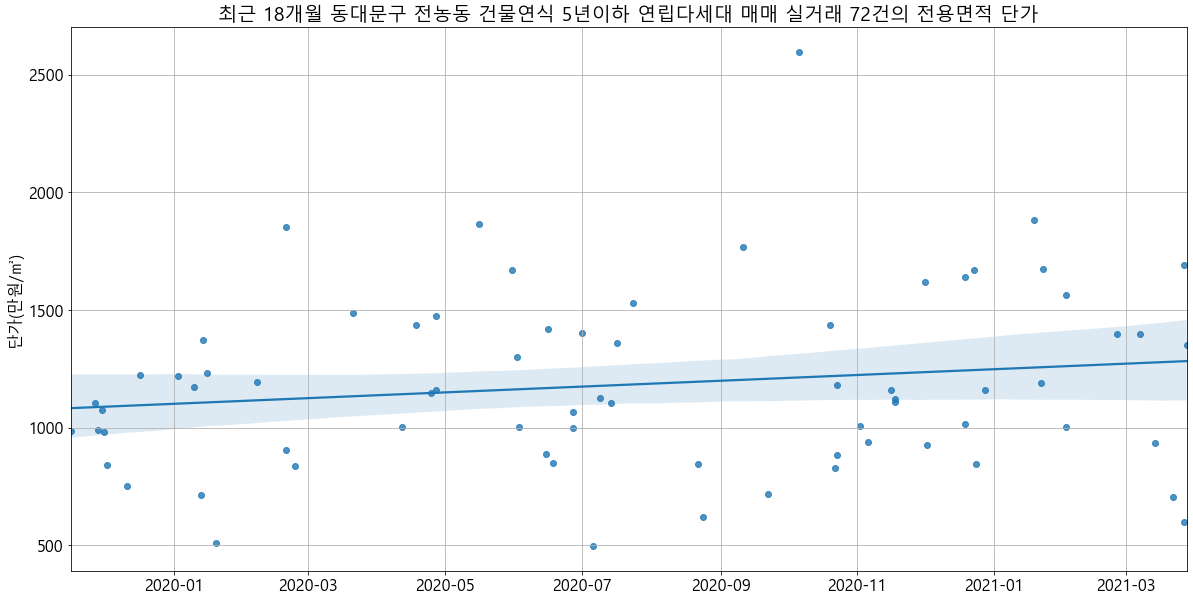

In [13]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [14]:
concat_df = pd.concat([target_df])

In [15]:
concat_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
561248,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),58.36,34.00,29700,3,2016.0,4.0,2020-01-20,508.910212,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561249,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),58.36,34.00,29000,2,2016.0,4.0,2020-07-06,496.915696,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561250,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),54.96,38.00,34000,4,2016.0,4.0,2020-08-24,618.631732,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561251,서울특별시 동대문구 전농동 9-4,사가정로20길 48,DH팰리스(9-4),57.48,35.00,34500,3,2016.0,5.0,2021-03-27,600.208768,5.0,대,978.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로한면(가),동대문구,전농동
561261,서울특별시 동대문구 전농동 103-33,전농로38가길 36,The 조은캐슬,26.91,18.31,22600,3,2016.0,3.0,2019-12-02,839.836492,5.0,대,396.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(불),동대문구,전농동


In [16]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [17]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(72, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
0,서울특별시 동대문구 전농동 103-116,전농로37길 32,그린빌리지,22.50,17.64,42000,2,2019.0,1.0,2020-05-16,1866.666667,2.0,대,231.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),동대문구,전농동,2231.821170
1,서울특별시 동대문구 전농동 103-116,전농로37길 32,그린빌리지,15.21,11.93,39500,3,2019.0,1.0,2020-10-06,2596.975674,2.0,대,231.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),동대문구,전농동,2231.821170
2,서울특별시 동대문구 전농동 103-131,전농로37길 13-8,멘토하우스가동,50.27,32.78,68000,3,2016.0,5.0,2021-03-28,1352.695445,5.0,대,321.0,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,소로각지,동대문구,전농동,1352.695445
3,서울특별시 동대문구 전농동 103-132,전농로37길 13-6,멘토하우스나동,42.23,27.84,55000,5,2016.0,4.0,2020-06-02,1302.391665,5.0,대,297.0,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,소로각지,동대문구,전농동,1432.630831
4,서울특별시 동대문구 전농동 103-132,전농로37길 13-6,멘토하우스나동,42.23,27.84,66000,5,2016.0,5.0,2021-02-02,1562.869998,5.0,대,297.0,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,소로각지,동대문구,전농동,1432.630831


In [18]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(34, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,단가평균
1,서울특별시 동대문구 전농동 103-116,전농로37길 32,그린빌리지,15.210,11.93,39500,3,2019.0,1.0,2020-10-06,2596.975674,2.0,대,231.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),동대문구,전농동,2231.821170
2,서울특별시 동대문구 전농동 103-131,전농로37길 13-8,멘토하우스가동,50.270,32.78,68000,3,2016.0,5.0,2021-03-28,1352.695445,5.0,대,321.0,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,소로각지,동대문구,전농동,1352.695445
4,서울특별시 동대문구 전농동 103-132,전농로37길 13-6,멘토하우스나동,42.230,27.84,66000,5,2016.0,5.0,2021-02-02,1562.869998,5.0,대,297.0,제2종일반주거지역,지정되지않음,주상기타,평지,세로장방,소로각지,동대문구,전농동,1432.630831
9,서울특별시 동대문구 전농동 103-184,전농로37가길 4,혜성루첸리(103-184),47.430,29.17,55000,5,2016.0,4.0,2020-04-27,1159.603626,5.0,대,179.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),동대문구,전농동,1143.902423
15,서울특별시 동대문구 전농동 103-228,전농로37길 33-1,하이프라자,28.650,19.84,40000,3,2019.0,2.0,2021-03-07,1396.160558,2.0,대,43.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,세로한면(불),동대문구,전농동,1466.225378
16,서울특별시 동대문구 전농동 103-30,전농로38나길 30,포에버빌,28.360,16.77,23500,2,2018.0,2.0,2020-10-22,828.631876,3.0,대,148.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,소로각지,동대문구,전농동,828.631876
17,서울특별시 동대문구 전농동 103-33,전농로38가길 36,The 조은캐슬,26.910,18.31,22600,3,2016.0,3.0,2019-12-02,839.836492,5.0,대,396.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(불),동대문구,전농동,839.836492
19,서울특별시 동대문구 전농동 103-377,전농로37길 36,(103-377),25.350,17.40,36000,4,2019.0,1.0,2020-06-16,1420.118343,2.0,대,212.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),동대문구,전농동,1307.328796
20,서울특별시 동대문구 전농동 103-49,전농로38가길 15-3,명가뷰,38.295,24.08,32000,4,2018.0,2.0,2020-02-24,835.618227,3.0,대,241.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,소로각지,동대문구,전농동,835.618227
21,서울특별시 동대문구 전농동 103-56,전농로36길 17,윤앤빌,35.870,21.35,25300,3,2016.0,5.0,2021-03-22,705.324784,5.0,대,436.0,제2종일반주거지역,지정되지않음,연립,평지,세로장방,소로각지,동대문구,전농동,705.324784


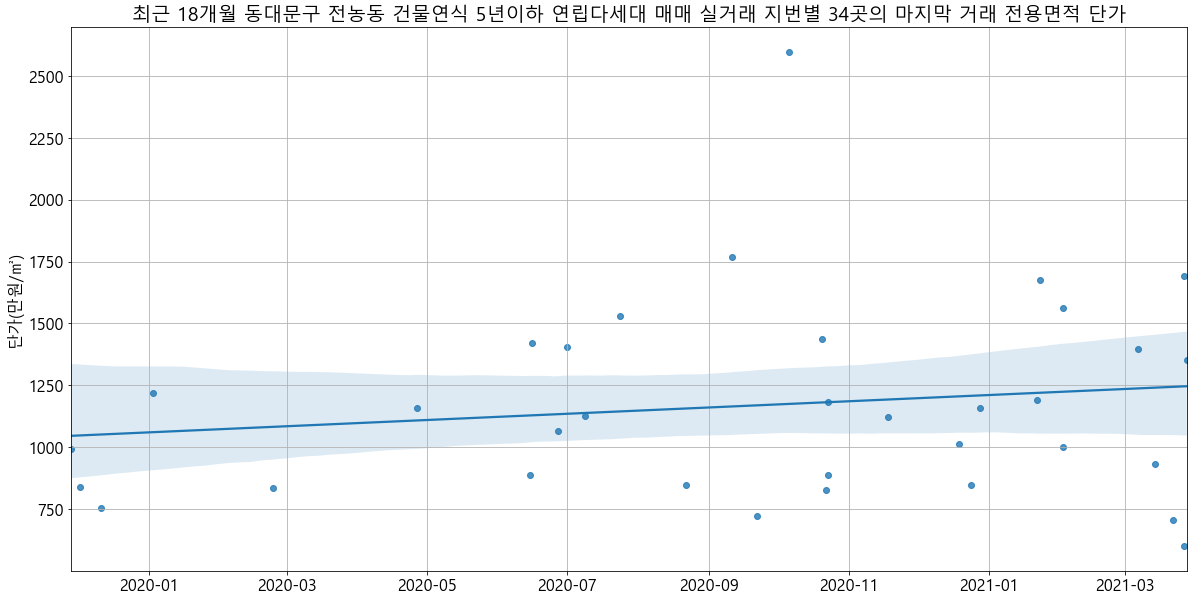

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

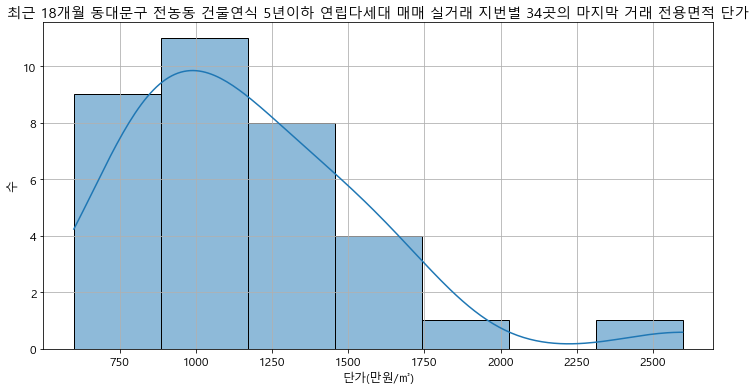

<Figure size 432x288 with 0 Axes>

In [20]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [21]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [22]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건물연식', '계약날짜', '단가(만원/㎡)', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건물연식,계약날짜,단가(만원/㎡),용도지역명1
0,서울특별시 동대문구 전농동 103-116,그린빌리지,2.0,2020-10-06,2596.975674,제2종일반주거지역
1,서울특별시 동대문구 전농동 103-131,멘토하우스가동,5.0,2021-03-28,1352.695445,제2종일반주거지역
2,서울특별시 동대문구 전농동 103-132,멘토하우스나동,5.0,2021-02-02,1562.869998,제2종일반주거지역
3,서울특별시 동대문구 전농동 103-184,혜성루첸리(103-184),5.0,2020-04-27,1159.603626,제2종일반주거지역
4,서울특별시 동대문구 전농동 103-228,하이프라자,2.0,2021-03-07,1396.160558,제2종일반주거지역
5,서울특별시 동대문구 전농동 103-30,포에버빌,3.0,2020-10-22,828.631876,제2종일반주거지역
6,서울특별시 동대문구 전농동 103-33,The 조은캐슬,5.0,2019-12-02,839.836492,제2종일반주거지역
7,서울특별시 동대문구 전농동 103-377,(103-377),2.0,2020-06-16,1420.118343,제2종일반주거지역
8,서울특별시 동대문구 전농동 103-49,명가뷰,3.0,2020-02-24,835.618227,제2종일반주거지역
9,서울특별시 동대문구 전농동 103-56,윤앤빌,5.0,2021-03-22,705.324784,제2종일반주거지역


In [23]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)

In [24]:
%%time
land_plans_df = pd.read_csv('./토지이용계획정보/original_land_plans_mapped.csv')
land_plans_df = land_plans_df.sort_values(['지번주소', '년']).drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년']).reset_index(drop=True)
print(land_plans_df.shape)
land_plans_df.head()

(986224, 354)
Wall time: 1min 28s


,지번주소,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가스공급시설,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고가도로,고도지구,고등학교,고속철도,고압선,공간시설미분류,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공시설용지,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공설화장시설,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원문화유산지구,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항,공항소음피해예상지역,공항소음피해지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광역복합환승센터,광장,교육환경보호구역,교차점광장,교통광장,교통운수시설미분류,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,군사기지_및_군사시설_보호구역,군사시설_보호구역,궤도,근린공원,근린광장,근린상업지역,기업형임대주택_공급촉진지구,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타도시방재시설,기타문화시설,기타방송통신시설,기타보건위생시설,기타사회복지시설,기타수도시설,기타시장시설,기타열공급설비,기타용도지역지구기타,기타용도지역지구미분류,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타전기공급설비,기타주차장시설,기타철도시설,기타폐기물처리시설,기타하수도시설,기타학교시설,기타환경기초시설,노외주차장,녹지,농수산물공판장및농수산물종합유통센터,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,등록문화재구역,리모델링지구,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,박물관,방송통신시설,방수설비,방재지구,방화지구,배수시설,변전소(전원개발사업구역),변전시설,보건위생시설미분류,보전녹지지역,보전산지,보전임지,보조간선도로,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제1구역(전술),비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업기술단지,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,생태_경관보전지역,생태_경관완충보전구역,생태_경관핵심보전구역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,소하천예정지,수도공급시설,수변공원,수질오염방지시설,수평표면구역,시_도_생태_경관보전지역,시_도야생생물보호구역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,시험림구역,아파트지구,액화석유가스충전시설,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,온천원보호지구,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,운동장,원추표면구역,원형보존지,유류저장및송유설비,유수시설,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반광장,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차운전학원,자동차전용도로,자동차정류장,자연경관지구,자연공원용도지구기타,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,재해위험지구기타,재활용시설,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(방공기지___1km),제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주간선도로,주거용지,주거환경개선지구,주요시설광장,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,집산도로,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,취수시설,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,토지형질변경규제지역,통제보호구역,통제보호구역(민통선이남_300m),통제보호구역(방공기지_500m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,하천미분류,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역,화장장,환경정비구역
0,서울특별시 강남구 개포동 100-0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,서울특별시 강남구 개포동 101-0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
from time import sleep
import requests
from urllib.parse import urlparse

# 지번주소로 도로명주소와 좌표를 다운로드함. 출처 - 행정안전부 도로명주소 안내시스템 개발자센터

def fetch_coor_data(addr_list):
    roadname_url = 'https://www.juso.go.kr/addrlink/addrLinkApi.do?'
    roadname_apikey = 'devU01TX0FVVEgyMDIxMDUwNDE1NTMwMDExMTEyNzc='
    coor_base_url = 'https://www.juso.go.kr/addrlink/addrCoordApi.do?'
    coor_apikey = 'devU01TX0FVVEgyMDIxMDIyNjExMDQwMDExMDg1ODU='
    # 도로명주소 검색 api key 만료일 2021년 8월 2일
    # 좌표검색 api key 만료일 2021년 5월 27일
    #apikey 만료시 https://www.juso.go.kr/addrlink/devAddrLinkRequestWrite.do?returnFn=write&cntcMenu=URL 가서 새로 받을 것.
    
    coor_data_df = pd.DataFrame({'지번주소':[], '도로명주소':[], 'x좌표':[], 'y좌표':[]})
    
    for i, address in enumerate(addr_list):     
        address_no_zero = address
        
        roadname_result = requests.get(roadname_url + 'confmKey=' + roadname_apikey + '&currentPage=1' + '&countPerPage=5' + '&keyword=' \
                                       + address_no_zero + '&resultType=json' + '&hstryYn=Y')
        sleep(1)
        roadname_info = roadname_result.json()['results']['juso']
        
        if roadname_info == []:
            print(address_no_zero)
            if address_no_zero.endswith('-0'):
                address_no_zero = address_no_zero[:-2]
            
            roadname_result = requests.get(roadname_url + 'confmKey=' + roadname_apikey + '&currentPage=1' + '&countPerPage=5' + '&keyword=' \
                                       + address_no_zero + '&resultType=json' + '&hstryYn=Y')
            sleep(1)
            roadname_info = roadname_result.json()['results']['juso']
            
            if roadname_info == []:
                print(address)
                print('was not able to get roadname info')
            
                continue
                                
        roadname_info = roadname_info[0]               
        
        coor_result = requests.get(coor_base_url + 'confmKey=' + coor_apikey + '&admCd=' + roadname_info['admCd']\
                                   + '&rnMgtSn=' + roadname_info['rnMgtSn'] + '&udrtYn=' + roadname_info['udrtYn']\
                                   + '&buldMnnm=' + roadname_info['buldMnnm'] + '&buldSlno=' + roadname_info['buldSlno']\
                                   + '&resultType=json')
        sleep(1)
        #return coor_result
        
        if coor_result.json()['results']['juso'] == None:
            print(address_no_zero)
            continue
        
        coor_info = coor_result.json()['results']['juso'][0]
        
        coor_x = pd.to_numeric(coor_info['entX'])
        coor_y = pd.to_numeric(coor_info['entY'])
        
        roadname_addr = roadname_info['roadAddrPart1']
        
        coor_data_df.loc[i,'지번주소'] = address
        coor_data_df.loc[i,'도로명주소'] = roadname_addr
        coor_data_df.loc[i, 'x좌표'] = coor_x
        coor_data_df.loc[i, 'y좌표'] = coor_y
        
    
    
    return coor_data_df

In [26]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [27]:
def get_year(x):
    if pd.isna(x) == True:
        return x
    else:
        return int(x.split('.')[0])

In [28]:
def date_modifier(x):
    # x is a string or datetime
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if '-' in x:
            x = x.replace('-', '.')
            
        splitted = x.split('.')
        
        if len(splitted) == 1:
            return np.nan
        else:
            return x.split(' ')[0]

In [29]:
def get_bd_type(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '오피' in x:
            return '오피스텔'
        else:
            return '연립다세대'

In [30]:
model_names = [f for f in os.listdir('./Training/training_data_ver_22/') if ('catboost_multiclass' in f) & ('lower_lr' not in f)]
model_names

['catboost_multiclass_0',
 'catboost_multiclass_1',
 'catboost_multiclass_2',
 'catboost_multiclass_3',
 'catboost_multiclass_4']

In [31]:
from catboost import CatBoostClassifier

In [32]:
basedir = './Training/training_data_ver_22/'
models_list = []
for name in tqdm(model_names):
    model = CatBoostClassifier().load_model(basedir + name)
    models_list.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


In [33]:
training_data_sample = next(pd.read_csv(basedir + 'training_data_ver_22.csv', chunksize=1))
print(training_data_sample.shape)
training_data_sample

(1, 307)


,지번주소,도로명주소,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,부동산유형,전용면적_classes,가격_면적,구,동,year_linear,year_sin,year_cos,distance_nearest_station,nearest_station_name,xnorm,ynorm,x_2nd,y_2nd,xy,년,지목명,토지면적_log,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,리모델링지구,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),보전산지,보전임지,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지조성사업지역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,통제보호구역,통제보호구역(민통선이남_300m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,서울특별시 강남구 개포동 1264-3,서울특별시 강남구 개포로31길 23-7,(1264-3),53.28,11500,1,1992.0,14.0,2006-08-29,1,10,215.840841,0,9,0.657534,-0.835925,-0.548843,735.633243,114,5167.325126,-8970.432841,1.335062e+07,4.023433e+07,-4.635314e+07,2006,3,4.761319,7,3,4,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
training_columns = training_data_sample.columns
print(len(training_columns))

307


In [35]:
cols_to_drop = ['지번주소', '도로명주소', '건물(단지)명', '전용면적(㎡)', '거래금액(만원)', '계약날짜', '가격_면적', '년', '가격_면적_classes']

In [36]:
training_cols = []
for col in training_columns:
    if col not in cols_to_drop:
        training_cols.append(col)

In [37]:
last_df['토지면적'] = last_df['토지면적'].apply(np.log)
last_df.rename(columns={'토지면적':'토지면적_log'}, inplace=True)

In [38]:
ls_cols = last_df.columns
ls_cols

Index(['지번주소', '지목명', '토지면적_log', '용도지역명1', '용도지역명2', '토지이동상황', '지형높이', '지형형상',
       '도로접면'],
      dtype='object')

In [39]:
ls_cols_to_drop = []

In [40]:
for col in ls_cols:
    if col not in training_cols:
        ls_cols_to_drop.append(col)

In [41]:
ls_cols_to_drop.remove('지번주소')

In [42]:
lp_cols = land_plans_df.columns
lp_cols

Index(['지번주소', '(한강)오염행위_제한지역', '(한강)폐기물매립시설_설치제한지역', '4대문안',
       '가로구역별_최고높이_제한지역', '가스공급설비', '가스공급시설', '가축사육제한구역', '개발제한구역', '개발진흥지구',
       ...
       '하천구역', '하천미분류', '학교', '학교시설보호지구', '학교이적지', '학교환경위생_정화구역',
       '현상변경허가_대상구역', '홍수관리구역', '화장장', '환경정비구역'],
      dtype='object', length=354)

In [43]:
lp_cols_to_drop = []

In [44]:
for col in lp_cols:
    if col not in training_cols:
        lp_cols_to_drop.append(col)

In [45]:
lp_cols_to_drop.remove('지번주소')

In [46]:
def house_area_into_classes(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        for i in range(100):
            if x <= ((i+1)*5):
                return '{}~{}'.format((i*5), (i+1)*5)
        return '500초과'

In [47]:
coor_minmax_df = pd.read_csv('./Training/training_data_ver_22/coor_minmax.csv')
coor_minmax_df

,xmax,xmin,ymax,ymin
0,971728.508488,938089.149737,1.965485e+06,1.937374e+06


In [48]:
xmax = coor_minmax_df['xmax'].iloc[0]
xmin = coor_minmax_df['xmin'].iloc[0]
ymax = coor_minmax_df['ymax'].iloc[0]
ymin = coor_minmax_df['ymin'].iloc[0]

In [49]:
subway_df = pd.read_csv('./지하철역/subway_coor_2.csv').sort_values(['역명']).reset_index(drop=True)
subway_df['역명'] = subway_df['역명'].apply(lambda x: x.split('_')[0]) + '_' + subway_df['노선명']
print(subway_df.shape)
subway_df.head()

(743, 6)


,지번주소,도로명주소,역명,노선명,x좌표,y좌표
0,서울 강북구 삼양로 519,서울특별시 강북구 삼양로 519,419민주묘지역_우이,우이,957082.039087,1.961221e+06
1,경기도 의정부시 평화로 633,경기도 의정부시 평화로 633,가능역_1,1,959847.359211,1.972179e+06
2,서울특별시 송파구 송파대로 257,서울특별시 송파구 송파대로 지하 257,가락시장역_3,3,966274.711075,1.943790e+06
3,서울특별시 송파구 송파대로 257,서울특별시 송파구 송파대로 지하 257,가락시장역_8,8,966274.711075,1.943790e+06
4,서울특별시 금천구 벚꽃로 309,서울특별시 금천구 벚꽃로 309,가산 디지털단지역_1,1,945410.718812,1.942663e+06


In [50]:
cat_cols = cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')['colname'].tolist()
cat_cols

['부동산유형',
 '구',
 '동',
 'nearest_station_name',
 '층',
 '지목명',
 '용도지역명1',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면',
 '전용면적_classes',
 '(한강)오염행위_제한지역',
 '(한강)폐기물매립시설_설치제한지역',
 '4대문안',
 '가로구역별_최고높이_제한지역',
 '가스공급설비',
 '가축사육제한구역',
 '개발제한구역',
 '개발진흥지구',
 '개발행위허가제한지역',
 '건축선',
 '건축용도지역기타',
 '건축용도지역미분류',
 '건축허가_착공제한지역',
 '경관광장',
 '경관녹지',
 '경관지구',
 '경관지구기타',
 '고도지구',
 '고등학교',
 '고속철도',
 '공공공지',
 '공공도서관',
 '공공문화체육시설미분류',
 '공공시설구역',
 '공공주택지구',
 '공공지원민간임대주택_공급촉진지구',
 '공공청사',
 '공용시설보호지구',
 '공원',
 '공원마을지구(공원집단시설지구)',
 '공원자연보존지구',
 '공원자연환경지구',
 '공익용산지',
 '공익임지',
 '공장설립승인지역',
 '공장설립제한지역',
 '공항소음피해예상지역',
 '공항시설보호지구',
 '과밀억제권역',
 '광로1류(폭_70M_이상)',
 '광로2류(폭_50M_70M)',
 '광로3류(폭_40M_50M)',
 '광역계획구역',
 '광장',
 '교육환경보호구역',
 '교통광장',
 '국가산업단지',
 '국가지정문화재구역',
 '국가하천',
 '국립공원',
 '국민임대주택단지예정지구',
 '국지도로',
 '국토이용용도지구기타',
 '근린공원',
 '근린광장',
 '근린상업지역',
 '기타공공공지시설',
 '기타공원시설',
 '기타교통시설',
 '기타녹지시설',
 '기타도로시설',
 '기타도시공간시설',
 '기타문화시설',
 '기타보건위생시설',
 '기타수도시설',
 '기타시장시설',
 '기타용도지역지구기타',
 '기타용지',
 '기타유통업무설비',
 '기타자동차정류장',
 '기타주차장시설

In [51]:
map_files = [f for f in os.listdir(basedir + 'feature_maps/') if f.endswith('.csv')]
map_files

['nearest_station_name_map.csv',
 '가격_면적_classes_map.csv',
 '구_map.csv',
 '도로접면_map.csv',
 '동_map.csv',
 '부동산유형_map.csv',
 '용도지역명1_map.csv',
 '전용면적_classes_map.csv',
 '지목명_map.csv',
 '지형높이_map.csv',
 '지형형상_map.csv',
 '층_map.csv',
 '토지이동상황_map.csv']

In [52]:
for map_file in map_files:
    map_df = pd.read_csv(basedir + 'feature_maps/' + map_file)
    print(map_df.shape)
    display(map_df.head())

(335, 3)


,Unnamed: 0,cat,map
0,0,419민주묘지역_우이,0
1,1,가락시장역_3,1
2,2,가산 디지털단지역_1,2
3,3,가양역_9,3
4,4,가오리역_우이,4


(199, 3)


,Unnamed: 0,cat,map
0,0,30~45,0
1,1,45~60,1
2,2,60~75,2
3,3,75~90,3
4,4,90~105,4


(25, 3)


,Unnamed: 0,cat,map
0,0,강남구,0
1,1,강동구,1
2,2,강북구,2
3,3,강서구,3
4,4,관악구,4


(12, 3)


,Unnamed: 0,cat,map
0,0,광대로한면,0
1,1,광대세각,1
2,2,광대소각,2
3,3,맹지,3
4,4,세로각지(가),4


(371, 3)


,Unnamed: 0,cat,map
0,0,가락동,0
1,1,가리봉동,1
2,2,가산동,2
3,3,가양동,3
4,4,가회동,4


(3, 3)


,Unnamed: 0,cat,map
0,0,아파트,0
1,1,연립다세대,1
2,2,오피스텔,2


(12, 3)


,Unnamed: 0,cat,map
0,0,개발제한구역,0
1,1,근린상업지역,1
2,2,유통상업지역,2
3,3,일반상업지역,3
4,4,자연녹지지역,4


(101, 3)


,Unnamed: 0,cat,map
0,0,0~5,0
1,1,5~10,1
2,2,10~15,2
3,3,15~20,3
4,4,20~25,4


(13, 3)


,Unnamed: 0,cat,map
0,0,공원,0
1,1,공장용지,1
2,2,답,2
3,3,대,3
4,4,도로,4


(5, 3)


,Unnamed: 0,cat,map
0,0,고지,0
1,1,급경사,1
2,2,완경사,2
3,3,저지,3
4,4,평지,4


(8, 3)


,Unnamed: 0,cat,map
0,0,가로장방,0
1,1,부정형,1
2,2,사다리형,2
3,3,삼각형,3
4,4,세로장방,4


(2, 3)


,Unnamed: 0,cat,map
0,0,지상,0
1,1,지하,1


(19, 3)


,Unnamed: 0,cat,map
0,0,공업기타,0
1,1,공업나지,1
2,2,공업용,2
3,3,다세대,3
4,4,단독,4


In [53]:
map_files.remove('가격_면적_classes_map.csv')

In [54]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*x)

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*x)

In [55]:
target_addr = '서울특별시 동대문구 전농동 1-70'

In [56]:
gu = target_addr.split(' ')[1]
dong = target_addr.split(' ')[2]
print(gu)
print(dong)

동대문구
전농동


In [57]:
timepoint = pd.to_datetime(datetime.datetime.now(), format='%Y.%m.%d')
timepoint

Timestamp('2021-05-10 16:11:09.265463')

In [58]:
bdtype = '연립다세대'
btyear = 2021

In [59]:
land_specs_df['토지이동상황'].value_counts()

단독          2587553
도로등         1628918
상업용          833384
다세대          784342
주상용          645523
주거기타         352130
아파트          326397
주거나지         325607
주상기타         232625
상업기타         182632
업무용          112527
자연림          111370
전             96351
연립            88350
하천등           83734
공원등           75373
상업나지          46166
공업용           36456
전기타           34474
주상나지          24243
토지임야          24131
공업기타          10582
주차장등          10364
답              8747
운동장등           8107
임야기타           6058
기타             6043
유해.혐오시설        5792
과수원            3925
답기타            3523
골프장 대중제        3008
공업나지           2515
조림             1641
공항             1492
위험시설           1090
콘도미니엄           306
발전소             300
특수기타            279
여객자동차터미널        164
고속도로휴게소          56
유원지               9
주.상복합용            1
Name: 토지이동상황, dtype: int64

In [60]:
current_usage = '연립'

In [61]:
addr_df = last_df[last_df['지번주소'] == target_addr]
print(addr_df.shape)
addr_df.head()

(1, 9)


,지번주소,지목명,토지면적_log,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
360172,서울특별시 동대문구 전농동 1-70,대,6.734592,제3종일반주거지역,지정되지않음,상업용,평지,부정형,세로각지(가)


In [62]:
addr_df = addr_df.merge(land_plans_df, on=['지번주소'])
print(addr_df.shape)
addr_df.head()

(1, 362)


,지번주소,지목명,토지면적_log,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가스공급시설,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고가도로,고도지구,고등학교,고속철도,고압선,공간시설미분류,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공시설용지,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공설화장시설,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원문화유산지구,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항,공항소음피해예상지역,공항소음피해지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광역복합환승센터,광장,교육환경보호구역,교차점광장,교통광장,교통운수시설미분류,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,군사기지_및_군사시설_보호구역,군사시설_보호구역,궤도,근린공원,근린광장,근린상업지역,기업형임대주택_공급촉진지구,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타도시방재시설,기타문화시설,기타방송통신시설,기타보건위생시설,기타사회복지시설,기타수도시설,기타시장시설,기타열공급설비,기타용도지역지구기타,기타용도지역지구미분류,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타전기공급설비,기타주차장시설,기타철도시설,기타폐기물처리시설,기타하수도시설,기타학교시설,기타환경기초시설,노외주차장,녹지,농수산물공판장및농수산물종합유통센터,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,등록문화재구역,리모델링지구,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,박물관,방송통신시설,방수설비,방재지구,방화지구,배수시설,변전소(전원개발사업구역),변전시설,보건위생시설미분류,보전녹지지역,보전산지,보전임지,보조간선도로,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제1구역(전술),비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업기술단지,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,생태_경관보전지역,생태_경관완충보전구역,생태_경관핵심보전구역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,소하천예정지,수도공급시설,수변공원,수질오염방지시설,수평표면구역,시_도_생태_경관보전지역,시_도야생생물보호구역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,시험림구역,아파트지구,액화석유가스충전시설,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,온천원보호지구,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,운동장,원추표면구역,원형보존지,유류저장및송유설비,유수시설,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반광장,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차운전학원,자동차전용도로,자동차정류장,자연경관지구,자연공원용도지구기타,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,재해위험지구기타,재활용시설,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(방공기지___1km),제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주간선도로,주거용지,주거환경개선지구,주요시설광장,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,집산도로,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,취수시설,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,토지형질변경규제지역,통제보호구역,통제보호구역(민통선이남_300m),통제보호구역(방공기지_500m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,하천미분류,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역,화장장,환경정비구역
0,서울특별시 동대문구 전농동 1-70,대,6.734592,제3종일반주거지역,지정되지않음,상업용,평지,부정형,세로각지(가),0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
addr_df = addr_df.drop(columns=ls_cols_to_drop + lp_cols_to_drop)

In [64]:
coor_df = fetch_coor_data([target_addr])
coor_df

,지번주소,도로명주소,x좌표,y좌표
0,서울특별시 동대문구 전농동 1-70,서울특별시 동대문구 한천로33길 61,961797.151165,1.953283e+06


In [65]:
addr_df['x좌표'] = coor_df['x좌표'].iloc[0]
addr_df['y좌표'] = coor_df['y좌표'].iloc[0]

In [66]:
print('가장 가까운 지하철역 역명과 거리를 가져오는 중...')

for j in tqdm(range(subway_df.shape[0])):
    station_name = subway_df['역명'].loc[j]
    subway_x = subway_df['x좌표'].loc[j]
    subway_y = subway_df['y좌표'].loc[j]

    addr_df['{}_distance'.format(station_name)] = np.sqrt((addr_df['x좌표'] - subway_x)**2\
    + (addr_df['y좌표'] - subway_y)**2)

distance_cols = [col for col in addr_df.columns if '_distance' in col]

addr_df['distance_nearest_station'] = addr_df[distance_cols].min(axis=1)
addr_df['nearest_station_name'] = addr_df[distance_cols].idxmin(axis=1).apply(lambda x: x.replace('_distance', ''))
addr_df = addr_df.drop(columns=distance_cols)

 22%|████████████████▊                                                             | 160/743 [00:00<00:00, 1599.64it/s]

가장 가까운 지하철역 역명과 거리를 가져오는 중...


100%|██████████████████████████████████████████████████████████████████████████████| 743/743 [00:00<00:00, 1108.70it/s]


In [67]:
addr_df['xnorm'] = (addr_df['x좌표'] - xmin - ((xmax - xmin)/2))
addr_df['ynorm'] = (addr_df['y좌표'] - ymin - ((ymax - ymin)/2))
addr_df['x_2nd'] = addr_df['xnorm']**2 / 2
addr_df['y_2nd'] = addr_df['ynorm']**2 / 2
addr_df['xy'] = addr_df['xnorm'] * addr_df['ynorm']

addr_df.drop(columns=['x좌표', 'y좌표'], inplace=True)

In [68]:
addr_df['층'] = '지상'
    
addr_df['부동산유형'] = bdtype

addr_df['건축년도'] = int(btyear)

addr_df['계약날짜기준_건물연식'] = timepoint.year - int(btyear)

addr_df['전용면적_classes'] = house_area_into_classes(60)

addr_df['구'] = gu
addr_df['동'] = dong

addr_df['year_linear'] = (timepoint - pd.to_datetime('2006-01-01')).days / 365

addr_df['year_sin'] = addr_df['year_linear'].apply(month_circular_sine_func)
addr_df['year_cos'] = addr_df['year_linear'].apply(month_circular_cosine_func)

addr_df['지목명'] = '대'

addr_df['토지이동상황'] = current_usage

addr_df = addr_df.drop(columns=['지번주소'])
addr_df = addr_df[training_cols]

In [69]:
print(addr_df.shape)
display(addr_df)

for file in map_files:
    map_df = pd.read_csv(basedir + 'feature_maps/' + file)
    map_dict = {}
    for j in range(map_df.shape[0]):
        map_dict[map_df.loc[j, 'cat']] = map_df.loc[j, 'map']

    addr_df[file.replace('_map.csv', '')] = addr_df[file.replace('_map.csv', '')].map(map_dict)

print(addr_df.shape)
display(addr_df)

(1, 299)


,층,건축년도,계약날짜기준_건물연식,부동산유형,전용면적_classes,구,동,year_linear,year_sin,year_cos,distance_nearest_station,nearest_station_name,xnorm,ynorm,x_2nd,y_2nd,xy,지목명,토지면적_log,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,리모델링지구,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),보전산지,보전임지,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지조성사업지역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,통제보호구역,통제보호구역(민통선이남_300m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,지상,2021,0,연립다세대,55~60,동대문구,전농동,15.364384,0.752667,-0.658402,1527.467099,회기역_1,6888.322053,1853.856296,2.372449e+07,1.718392e+06,1.276996e+07,대,6.734592,제3종일반주거지역,연립,평지,부정형,세로각지(가),0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(1, 299)


,층,건축년도,계약날짜기준_건물연식,부동산유형,전용면적_classes,구,동,year_linear,year_sin,year_cos,distance_nearest_station,nearest_station_name,xnorm,ynorm,x_2nd,y_2nd,xy,지목명,토지면적_log,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,리모델링지구,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),보전산지,보전임지,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지조성사업지역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,통제보호구역,통제보호구역(민통선이남_300m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,0,2021,0,1,11,10,297,15.364384,0.752667,-0.658402,1527.467099,330,6888.322053,1853.856296,2.372449e+07,1.718392e+06,1.276996e+07,3,6.734592,9,11,4,1,4,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
from catboost import Pool

In [71]:
preds_list = []
for model in models_list:
    addr_pool = Pool(addr_df, cat_features=cat_cols)
    preds = model.predict_proba(addr_pool)
    preds_list.append(preds)

mean_preds = np.mean(preds_list, axis=0)

In [72]:
y_map_df = pd.read_csv(basedir + 'feature_maps/가격_면적_classes_map.csv')
print(y_map_df.shape)
y_map_df.head()

(199, 3)


,Unnamed: 0,cat,map
0,0,30~45,0
1,1,45~60,1
2,2,60~75,2
3,3,75~90,3
4,4,90~105,4


In [73]:
y_map_df['확률'] = mean_preds.T

In [74]:
y_map_df

,Unnamed: 0,cat,map,확률
0,0,30~45,0,7.165155e-09
1,1,45~60,1,1.795016e-07
2,2,60~75,2,8.968511e-06
3,3,75~90,3,4.979042e-06
4,4,90~105,4,1.759229e-06
5,5,105~120,5,5.902677e-08
6,6,120~135,6,1.595561e-06
7,7,135~150,7,9.799374e-08
8,8,150~165,8,3.285343e-06
9,9,165~180,9,5.174537e-08


c:\users\max6296\ml\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


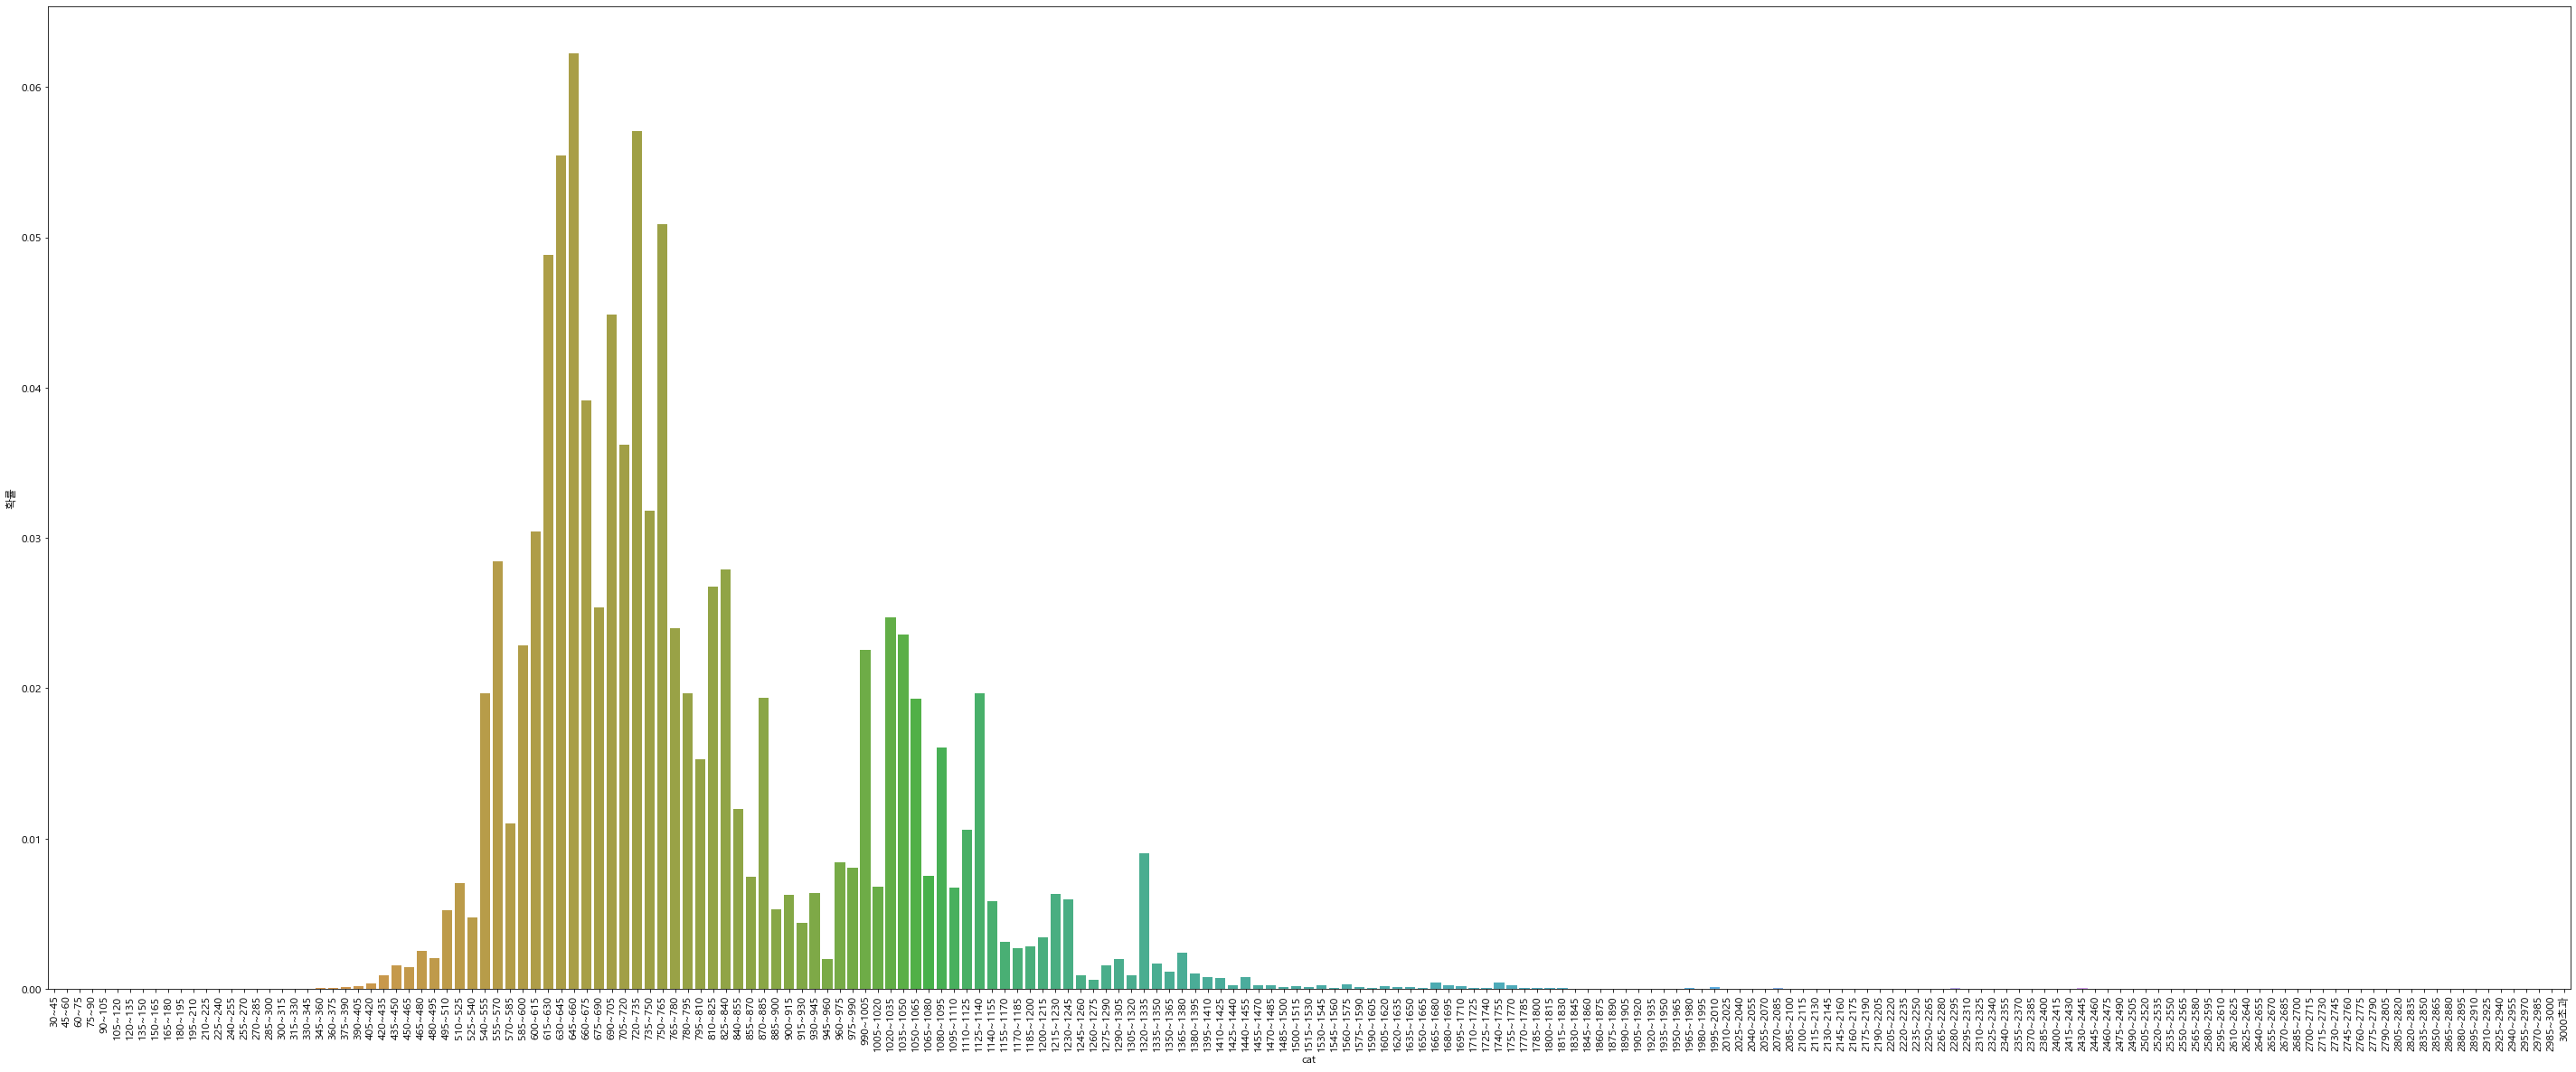

<Figure size 432x288 with 0 Axes>

In [75]:
fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
ax.set_xticklabels(labels=y_map_df['cat'], rotation = 90)
sns.barplot(x=y_map_df['cat'], y=y_map_df['확률'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/기계학습_결과_확률분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()